# Compute the SN

In [2]:
import os
import random
import numpy as np
from scipy.interpolate import interp1d

import galsim
import astropy
import astropy.units as units
import cosmology
import sep
import fitsio

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams["font.family"] = "serif"
plt.rcParams['text.usetex'] = False
%matplotlib inline

from scipy.special import jn, jn_zeros
from hankel_transform import *
from power_spectra import *
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from matplotlib.colors import LogNorm
from scipy.signal import savgol_filter
import scipy.integrate as integrate
cosmo_h=cosmo.clone(H0=70)

In [3]:
# Useful constants
lsun = 3.846e33  # erg/s
pc = 3.085677581467192e18  # in cm
lightspeed = 2.998e18  # AA/s
ckms = 2.998e5  # km/s
jansky_mks = 1e-26
jansky_cgs = 1e-23
#set cosmology
cosmo_for_sn = cosmology.Cosmo(H0=70, omega_m = 0.3)

In [4]:
#Collecting area of telescope in cm^2
area = 469530 #HSC
#pizelsize : fix for now to 0.18"
pixel_scale = 0.17 # arcsec/pixel
#image size
length = 64 #pixels

In [5]:
def compute_sn(redshift, wave_cen, filter_width, exptime, M_star, gal_r50, SED_model):
    
    datapath = "/Users/yifei/work/dwarf/computesn"

    # Initialize (pseudo-)random number generator
    random_seed = 1234567
    rng = galsim.BaseDeviate(random_seed)
    
    #distance luminosity in pc
    dl = cosmo_for_sn.Dl(0.0,redshift)*10**6 
    # value to go from L_sun/AA to erg/s/cm^2/AA at 10pc
    to_cgs_at_10pc = lsun / (4.0 * np.pi * (pc*10)**2)
    to_cgs_at_dl = lsun / (4.0 * np.pi * (pc*dl)**2)
    
    # Generate the artificial narrowband filter (nb) with sigmoid damping
    def _sigmoid(x):
        return 1. / (1. + np.exp(-x))
    peak_response=1.0
    wave_margin=10
    #if filter_width < 20:
    #    raise Exception("The filter should be at least 20 Anstrom wide.")
    half_width = int(filter_width / 2) + wave_margin
    wavelength = np.arange(half_width * 2) + wave_cen - half_width
    half_window = np.arange(half_width) - wave_margin
    response_curve = np.concatenate([_sigmoid(half_window), _sigmoid(half_window)[::-1]]) * peak_response
    filter_func = interp1d(wavelength, response_curve, kind=3)
    filter_nb = galsim.Bandpass(filter_func, wave_type='Ang',
                                blue_limit=min(wavelength), red_limit=max(wavelength)).withZeropoint(zeropoint='AB')
    
    # Read the broadband filters (here HSC r2-band)
    filter_filename = os.path.join(datapath, 'share/bandpasses/hsc_r2_v2018.dat')
    filter_r = galsim.Bandpass(filter_filename, wave_type='Ang').withZeropoint(zeropoint='AB')
    filter_r = filter_r.thin(rel_err=1e-4)
    
    # Read in galaxy SEDs from fsps (with emission lines)
    dwarf_seds = np.load('dwarf_sample_gaussian_test.npy')
    dwarf_wave = dwarf_seds['wave'][SED_model]
    dwarf_em = dwarf_seds['spec_em'][SED_model] #with emission lines
    #convert spec_em (in Lsun/Ang) into erg/s/cm^2/Ang at dl
    dwarf_em = dwarf_em*to_cgs_at_dl#*exptime
    #spec_em is the spectra of a galaxy with stellar mass equal to dwarf_seds['mstar']
    #here convert it into M_star
    dwarf_em = dwarf_em/dwarf_seds['mstar'][SED_model]*10**M_star
    sed_func_em = interp1d(dwarf_wave, dwarf_em, kind=3)
    SED_dwarf_em = galsim.SED(sed_func_em, wave_type=units.AA, 
                           flux_type=units.erg/(units.s * units.cm**2)/units.AA)
    
    # Read in galaxy SEDs from fsps (continumm only)
    dwarf_ne = dwarf_seds['spec_ne'][SED_model] #continumm only
    #convert spec_ne (in Lsun/Ang) into erg/s/cm^2/Ang at dl
    dwarf_ne = dwarf_ne*to_cgs_at_dl#*exptime
    #spec_ne is the spectra of a galaxy with stellar mass equal to dwarf_seds['mstar']
    #here convert it into M_star
    dwarf_ne = dwarf_ne/dwarf_seds['mstar'][SED_model]*10**M_star
    sed_func_ne = interp1d(dwarf_wave, dwarf_ne, kind=3)
    SED_dwarf_ne = galsim.SED(sed_func_ne, wave_type=units.AA, 
                           flux_type=units.erg/(units.s * units.cm**2)/units.AA)

    # Define the galaxy profile (here exponential)
    mono_gal = galsim.Exponential(half_light_radius=gal_r50)
    #mono_gal = galsim.Gaussian(fwhm=gal_r50)
    gal_SED_em = SED_dwarf_em.atRedshift(redshift)
    gal_em = mono_gal * gal_SED_em
    gal_SED_ne = SED_dwarf_ne.atRedshift(redshift)
    gal_ne = mono_gal * gal_SED_ne

    # Read in the sky spectra
    spec_sky = os.path.join(datapath, 'share/SEDs/SKY_OPTICAL_SPECTRUM_TEMPLATE_GUNN.txt')
    spec_sky = np.genfromtxt(spec_sky,names=('sky_wave','sky_flux_1','sky_flux_2'))
    sky_wave = spec_sky['sky_wave']
    sky_flux = spec_sky['sky_flux_2']*271725
    spec_sky_func = interp1d(sky_wave, sky_flux, kind=3)
    SED_sky = galsim.SED(spec_sky_func, wave_type=units.AA, 
                           flux_type=units.astrophys.photon/(units.s * units.m**2)/units.um)
    
    # Convolve the PSF
    PSF = galsim.Moffat(fwhm=0.6, beta=2.5)
    galfinal_em = galsim.Convolve([gal_em, PSF])
    galfinal_ne = galsim.Convolve([gal_ne, PSF])

    
    # Generate the image of the galaxy with emission lines
    # Draw profile through the filters
    img = galsim.ImageF(length, length, scale=pixel_scale)   
    if filter_number == 1:
        galfinal_em.drawImage(filter_r, image=img, area=area, exptime=exptime)
    if filter_number == 0:
        galfinal_em.drawImage(filter_nb, image=img, area=area, exptime=exptime)
    #add sky noise
    #sky level increases with exposure time
    if filter_number == 1:
        sky_level = SED_sky.calculateFlux(filter_r) * exptime #counts / arcsec^2
    if filter_number == 0:
        sky_level = SED_sky.calculateFlux(filter_nb) * exptime #counts / arcsec^2
    sky_level_pixel = sky_level * pixel_scale**2
    gain = 3. # e- / ADU
    read_noise = 0.
    noise = galsim.CCDNoise(rng, gain=gain, read_noise=read_noise, sky_level=sky_level_pixel)
    img.addNoise(noise)
    # Save the image
    #Imageflux is photons/pixels
    out_filename = os.path.join('/Users/yifei/work/dwarf/computesn', 'computesn_em.fits')
    galsim.fits.write(img, out_filename)
    
    # Generate the image of the galaxy with continumm only
    # Draw profile through the filters
    img = galsim.ImageF(length, length, scale=pixel_scale)   
    if filter_number == 1:
        galfinal_ne.drawImage(filter_r, image=img, area=area, exptime=exptime)
    if filter_number == 0:
        galfinal_ne.drawImage(filter_nb, image=img, area=area, exptime=exptime)
    #add sky noise
    #sky level increases with exposure time
    if filter_number == 1:
        sky_level = SED_sky.calculateFlux(filter_r) * exptime #counts / arcsec^2
    if filter_number == 0:
        sky_level = SED_sky.calculateFlux(filter_nb) * exptime #counts / arcsec^2
    sky_level_pixel = sky_level * pixel_scale**2
    gain = 3. # e- / ADU
    read_noise = 0.
    noise = galsim.CCDNoise(rng, gain=gain, read_noise=read_noise, sky_level=sky_level_pixel)
    img.addNoise(noise)
    # Save the image
    #Imageflux is photons/pixels
    out_filename = os.path.join('/Users/yifei/work/dwarf/computesn', 'computesn_ne.fits')
    galsim.fits.write(img, out_filename)
    
    # Return the useful numbers
    if filter_number == 1:
        gal_mag_em = gal_SED_em.calculateMagnitude(filter_r)
        gal_mag_ne = gal_SED_ne.calculateMagnitude(filter_r)
    if filter_number == 0:
        gal_mag_em = gal_SED_em.calculateMagnitude(filter_nb)
        gal_mag_ne = gal_SED_ne.calculateMagnitude(filter_nb)

    return gal_mag_em, gal_mag_ne, sky_level_pixel

# Run Monte Carlo simulation

In [6]:
#which filter to use (0 for nb, 1 for HSC_r2)
filter_number = 0
#fixed number of nights
Nnights = 50
#hours per night: assume 8
hours_night = 8
#assume size of imager in deg^2
imager_size = 1 
# HSC wide
survey_area = 1000.0 #in deg^-2
#filter center
wave_cen = 6564*(1+0.1) #AA
#filter width
filter_width = 400 #AA
#texp : exposure time
exptime = 900# sec

In [6]:
galaxy_number = []
galaxy_detection = []
galaxy_redshift = []
galaxy_M_star = []
galaxy_gal_r50 = []
galaxy_SED_model = []
galaxy_gal_mag_em = []
galaxy_gal_mag_ne = []
galaxy_sky_level_pixel = []
galaxy_delta_mag = []
galaxy_SN_detection = []

n=2000
k=0
for i in range(n):
    #redshift (central wavelength is computed from z)
    redshift = random.uniform(0.02,0.2)
    #filter center
    wave_cen = 6564*(1+0.1) #AA
    #filter width
    filter_width = 400 #AA
    #texp : exposure time
    exptime = 900# sec
    #log stellar mass
    M_star = random.uniform(8.0,9.0)
    #size : galaxy size
    gal_r50_Mpc = random.uniform(0.2,3.0)/1000 #0.2-3.0 kpc
    gal_r50 = gal_r50_Mpc/cosmo.angular_diameter_distance(redshift).value*(60*60*180/np.pi) #arcsec
    #SED model number (0-3999)
    SED_model = random.randint(0,3999)
    
    gal_mag_em, gal_mag_ne, sky_level_pixel = compute_sn(redshift, wave_cen, filter_width, exptime, M_star, gal_r50, SED_model)
    
    data_em = fitsio.read("computesn_em.fits")
    data_ne = fitsio.read("computesn_ne.fits")
    
    # Do the photometry
    skynoise = np.sqrt(sky_level_pixel)
    flux_em, fluxerr_em, flag_em = sep.sum_circle(data_em, length/2, length/2, gal_r50/pixel_scale*5, err=skynoise, gain=1.0)
    SNR_em = flux_em/fluxerr_em

    skynoise = np.sqrt(sky_level_pixel)
    flux_ne, fluxerr_ne, flag_ne = sep.sum_circle(data_ne, length/2, length/2, gal_r50/pixel_scale*5, err=skynoise, gain=1.0)

    flux_ratio = flux_em/flux_ne
    delta_mag = 2.5*np.log10(flux_ratio)
    SN_detection = (flux_em - flux_ne)/fluxerr_em

    if SN_detection>=4.0:
        k=k+1
        
    galaxy_number.append(i+1)
    galaxy_detection.append(k)
    galaxy_redshift.append(redshift)
    galaxy_M_star.append(M_star)
    galaxy_gal_r50.append(gal_r50)
    galaxy_SED_model.append(SED_model)
    galaxy_gal_mag_em.append(gal_mag_em)
    galaxy_gal_mag_ne.append(gal_mag_ne)
    galaxy_sky_level_pixel.append(sky_level_pixel)
    galaxy_delta_mag.append(delta_mag)
    galaxy_SN_detection.append(SN_detection)
    
    print(i+1,k,redshift,M_star,SN_detection)

1 1 0.05177201438773604 8.180505770956248 8.959328341057
2 2 0.10078195690605304 8.24502585469405 17.033494552020496
3 3 0.07953991069894481 8.442363558050353 42.93248691829831
4 4 0.10189865601959941 8.557903860301481 34.738862446579674
5 4 0.06171769545877155 8.28540871733511 3.2935868015837317
6 4 0.1924859080634753 8.70693037107627 0.3998529330447757
7 5 0.08444454944223719 8.144866071320324 7.417495047760976
8 5 0.19513671413209277 8.344488012715718 0.8678645776851249
9 6 0.15446865627427533 8.997435499355426 4.127405850422445
10 6 0.13565067796670535 8.513798705305991 0.5481842788623568
11 7 0.10396831556716968 8.539279567841524 27.869315018327082
12 7 0.17099986918419577 8.706957448679297 0.8802275179579143
13 8 0.06378720784476745 8.477535135611191 23.783388696372135
14 9 0.0504358681719274 8.283131350775458 7.038009217970387
15 10 0.027584772412002002 8.343497000737997 12.987669251387219
16 11 0.07577284948927536 8.130966883895509 43.93776685875378
17 11 0.14238420364442994 8.

133 78 0.09677714459280266 8.241975563735043 29.933291909388856
134 78 0.1434832941388768 8.489642024135007 2.5802664524141026
135 78 0.14914837513008858 8.768427019968605 2.589764825801413
136 79 0.07588911679129214 8.626105751602374 33.57664472016353
137 80 0.11321290966151334 8.503823484214017 12.230912534654378
138 81 0.09450831924537735 8.239607003361499 26.385942037100463
139 81 0.03424059742652853 8.323082244353696 3.6121920017531624
140 81 0.15475975521496765 8.04861157784261 0.4923339896982907
141 82 0.07418539962263543 8.095819054286466 9.976324917486684
142 83 0.026977004231234447 8.133902724703127 5.4683889488955355
143 83 0.1551583931189706 8.262170731648999 0.5735237039108174
144 83 0.16747467221861642 8.100528931778404 0.7357701705515511
145 84 0.08692850273175819 8.0666762351383 9.44595806294092
146 85 0.06922858017295161 8.014116200844882 4.1863756009635535
147 85 0.1774837377061554 8.824549609385258 1.9665518439780667
148 86 0.06710286934384578 8.675345831877706 23.29

262 152 0.03121333503350108 8.542050139954855 8.533086229412703
263 153 0.10168022799666895 8.741448304269955 20.72830332780005
264 153 0.18750688712467964 8.374202233641853 0.3855725952448359
265 154 0.10642453653942316 8.052385374543203 5.290903664690747
266 154 0.1403212735269516 8.762653014166395 2.6623576335153953
267 154 0.1786568165308447 8.709039662776162 0.8757721045104706
268 155 0.0320941116638257 8.516278283728067 17.395647837593096
269 156 0.020060441418515193 8.240722013108615 12.38864793535969
270 157 0.033042970276773435 8.632904784661271 10.780864469658857
271 158 0.05835093022723105 8.530820768101508 20.501884028938612
272 159 0.08953061696886762 8.20253322176284 12.146661255647267
273 160 0.0854150664178658 8.359843248675176 8.109757805548226
274 160 0.1753896187595622 8.415452532739735 0.8386084851843529
275 160 0.15303541977552507 8.714399704081977 1.4382931055847563
276 161 0.10328626377565797 8.954324933436064 118.66650509603683
277 161 0.13208893517959788 8.3211

390 234 0.06750023395139787 8.50537247791607 27.59312788775419
391 235 0.05127853119549705 8.152790369008422 13.944510242104915
392 236 0.058430436749867296 8.259061603615502 12.908941607400052
393 236 0.14484649247618542 8.07715661887271 1.0769162629082956
394 237 0.10292855078822626 8.758284261013186 91.12770089868955
395 238 0.08761802544168312 8.865846973836279 75.4786300968823
396 239 0.04862334912332608 8.035376076274906 6.166634119366322
397 240 0.11256511833181827 8.178566632467591 8.522678985860686
398 241 0.13060193976251322 8.81003005791819 4.8700229407461775
399 242 0.1003051573543712 8.722280020786235 105.61272490852683
400 243 0.04978534222031224 8.940322465554559 17.186345119760528
401 243 0.1692676329839027 8.861059550368186 3.443249056104451
402 243 0.17795277290123396 8.498678212359836 0.9155203281120164
403 244 0.10364736898080769 8.212237890831636 10.366212661477098
404 244 0.19279098479869763 8.93437612391397 2.0818513047640423
405 245 0.03406397856268445 8.4697134

518 311 0.054744099544594194 8.123287719169944 6.29300249872556
519 311 0.17443556927702417 8.112465327435197 0.5323989499124152
520 311 0.1941667168698792 8.763754106493463 1.053588182040004
521 312 0.11279760926892471 8.577865016420013 22.698165613020375
522 312 0.18266367218704535 8.53213173938748 0.3203212984050382
523 313 0.026554515251764946 8.296008653259488 10.669567793311996
524 313 0.14650408419898098 8.070894320473792 0.40943332238537106
525 313 0.18644488730146538 8.137091479034332 0.3393014413225035
526 314 0.06717217187104906 8.460313052601936 76.55827976421529
527 315 0.035018355530826224 8.733000654003629 18.309725092321095
528 316 0.04442679655734712 8.126285289471104 4.301857722903697
529 317 0.07161268355972927 8.620835500835486 61.85697408342268
530 318 0.1301488870197268 8.759185689924038 8.147401355342915
531 318 0.15181553167759815 8.016907884914799 0.3932994391828898
532 319 0.12125579439248738 8.316304586060241 4.2439791887594
533 320 0.024666680898020342 8.808

646 392 0.08575598979974024 8.625141522872509 45.82174492554378
647 393 0.025236721091045584 8.985263629784502 46.58909031986881
648 394 0.10847463804172908 8.764001765914234 26.56304250351602
649 394 0.05688656051262987 8.627366527559424 3.913142666412788
650 395 0.0675413264464699 8.964925016040779 42.123081978074474
651 395 0.1637816871597212 8.892125640364032 2.124963506412455
652 396 0.1259769919609412 8.703186489551147 11.764643332222212
653 396 0.1447927125774622 8.173559330436545 0.2629352859281282
654 396 0.036094903756525534 8.052759568395675 2.474907410318738
655 397 0.05077531016777166 8.26815140200817 17.38132365880226
656 397 0.16187052923975342 8.527856357659749 0.9995631416387377
657 397 0.16689617076134552 8.79535205548951 0.8068302979941194
658 397 0.1753927656114299 8.726120674710634 1.0677496216346996
659 398 0.11283590040110304 8.638398463944757 19.87244215572985
660 399 0.03555603388828793 8.339932194904918 8.329788302605701
661 400 0.09370800498266951 8.288271803

774 466 0.13432840593836765 8.71710005242066 1.3038976242825067
775 466 0.16770940227853512 8.698559699869548 1.6200327462097484
776 467 0.0907002131421375 8.39434293062169 13.136214041697837
777 467 0.18602418039838878 8.888295388044417 1.2632492252674599
778 467 0.19520468663531465 8.833775646063703 2.9565538784965697
779 468 0.1181517912977652 8.731541702482557 43.55896621240198
780 469 0.04065153759054846 8.943160921924648 6.829776917178255
781 469 0.182060979718137 8.669620679756687 0.7773517626084016
782 470 0.0662235229915907 8.280354485666399 4.237349673445206
783 471 0.08460101974346712 8.13020973987353 19.02583865291721
784 472 0.062454018087382004 8.857525907490466 13.188392177222541
785 473 0.10776589337193489 8.53487489507987 16.22971947291924
786 473 0.13151997907142463 8.01136886745588 0.2568450727010911
787 473 0.1760353400464283 8.74420912585246 1.4669564797402328
788 474 0.1141997413186646 8.661148907315946 32.774435101293854
789 475 0.09740903402102553 8.023669935629

902 541 0.13659907908108662 8.788953489685158 2.485107413299513
903 542 0.12540502704386478 8.298087603616187 5.818264724049896
904 542 0.037738953361109176 8.02142537250761 2.4118199014362713
905 543 0.05704719723038308 8.447145719483432 4.7294060429916325
906 543 0.19815870150975576 8.937941861927408 1.1573375663599677
907 544 0.036097099103255044 8.938556483333038 25.285556411663887
908 544 0.18019300904893118 8.91782369725573 3.445954332533402
909 545 0.025032750771568885 8.34861059891159 19.476823334736437
910 545 0.1653908085377821 8.449551888243763 0.9009665396756157
911 545 0.15592840962630705 8.405177743262726 0.3882596914693041
912 546 0.03618738227313482 8.100971496847963 5.815353953907262
913 547 0.0913326176177262 8.091664093435577 12.08120677698487
914 548 0.12409794710327039 8.620830737616366 13.64488593739126
915 549 0.09127371235545644 8.348643387938852 30.99412783720193
916 550 0.1456641682312097 8.71802104324729 5.097758419889322
917 551 0.04801138002047699 8.9442702

1030 617 0.10942201022725949 8.60198639733198 38.336153677495155
1031 618 0.0703806041221368 8.57180188579082 37.509923271390505
1032 618 0.17672400468224184 8.328228054988775 0.5862875076070257
1033 619 0.06108122962164447 8.140142790085314 8.967589264438562
1034 620 0.04635961693587603 8.18698122059432 11.62477470717818
1035 621 0.09294436144188895 8.400277088534407 8.467838598655675
1036 622 0.02943876524026144 8.013320952176596 7.477143923689548
1037 622 0.14177379758433262 8.243058917149812 0.5571071872235416
1038 623 0.09247690219183004 8.737136540151843 128.5176683390826
1039 623 0.15192169574341582 8.685760838760437 2.827117636106678
1040 623 0.18614498548876596 8.998946527024618 1.60561272752552
1041 623 0.11844390064944552 8.159779010554768 3.1616989435481426
1042 623 0.13317498274336914 8.63853148031421 0.8857992094190739
1043 623 0.14719217593010503 8.02728748093203 0.33228257157584834
1044 624 0.11053622328443695 8.897972702772947 105.0495465445881
1045 625 0.0889161521187

1156 692 0.04815037232048813 8.665851652805777 9.513696444195308
1157 692 0.032762143347003767 8.01972963438462 1.9095476105848572
1158 693 0.13249987285385495 8.9726311327664 12.829822810511587
1159 693 0.17149563375748747 8.200197515113292 0.6396590596094661
1160 693 0.17450269598011678 8.317402812627451 0.40860735097753814
1161 693 0.18990707445172053 8.180693112174524 -0.026516309290113924
1162 694 0.02612798255014416 8.760668119906397 17.226726250710737
1163 695 0.12740893727390576 8.971203964881074 77.70323928124789
1164 696 0.08901099898420999 8.434273463644631 20.498648295883527
1165 696 0.16929116993331841 8.535894241629862 1.0783190625824592
1166 696 0.1404001219850189 8.35903517671811 0.8985141350629894
1167 696 0.16712189638548788 8.06852376516941 0.5035076110800754
1168 697 0.11510479683501981 8.494234215894673 15.649565622414512
1169 697 0.14092191604492754 8.267515451185144 1.187718704272495
1170 698 0.08699673640611585 8.198208175903037 39.22409536433176
1171 699 0.0752

1282 764 0.07814714876118783 8.202001307932886 31.837166334106172
1283 765 0.07363947337292065 8.402684200942772 76.17994680178073
1284 766 0.11449859302236781 8.404506740295085 39.076775294478225
1285 767 0.10322143924825763 8.164064387368356 32.80756730224562
1286 768 0.041893119460652474 8.497152872682184 5.004195236947415
1287 769 0.10547387747214305 8.5740262913068 34.88764890651026
1288 770 0.08029122985078027 8.495490223658841 17.270439776786844
1289 770 0.1895983518583467 8.57148821212418 0.21392432349819349
1290 770 0.14675858468911215 8.71199487061356 2.0941935824246536
1291 771 0.1132124292130058 8.04136153779899 4.071859799758839
1292 771 0.19200225146778455 8.111000879112453 0.826301595067701
1293 772 0.09701938815924809 8.648509356621023 48.42578672674785
1294 773 0.11420251120251698 8.68393366409404 17.319320997897773
1295 773 0.15592741202766172 8.438537726803485 1.0380674576439861
1296 774 0.11241231818433854 8.10769450597479 7.636767832874745
1297 774 0.17634555778821

1408 838 0.031599410563417196 8.593154000357995 13.07654285269922
1409 838 0.15345243053515478 8.16994887719487 0.49877137670248056
1410 839 0.09516168801703666 8.410140549331329 79.2884322066805
1411 840 0.07589853040080474 8.188770665010225 17.23450656186932
1412 841 0.12105435003812777 8.284240749996632 9.449796547471093
1413 841 0.18473513406561592 8.245198240102066 0.41839077404824176
1414 841 0.14430194966064924 8.497418688862115 1.0866235900698087
1415 842 0.08511032242823208 8.355738230874598 20.265172303546
1416 842 0.18067410657323862 8.57805010917658 0.43096951032198394
1417 843 0.08602561235340174 8.815789968694977 93.63953848897197
1418 844 0.026297449305315558 8.70109646866457 27.969938126924664
1419 845 0.089023565386796 8.53391146312077 101.02756876165554
1420 846 0.08999471316731447 8.132330656048444 18.621569141835607
1421 847 0.14939660818616962 8.660414543082855 6.13242691419389
1422 847 0.15400621840301804 8.07189992333386 0.6603140161542733
1423 848 0.120477539155

1534 921 0.12746227385484857 8.884310367999994 48.78516808142282
1535 922 0.029092646067718216 8.304572019318456 15.438272157750054
1536 923 0.09181417937303242 8.841554686826505 178.77796524351055
1537 923 0.13457965182494627 8.75670412498459 3.4787283695480435
1538 924 0.04669561567259945 8.48910395143163 22.591788792819923
1539 924 0.14475878505981413 8.109971251243724 0.5334499976887594
1540 924 0.1664382368519704 8.006689399856546 0.07788643013023781
1541 924 0.13994375083366178 8.606016840880649 1.6986862194352972
1542 925 0.11515191831420414 8.62236449630027 19.05538291909983
1543 926 0.10419153179529389 8.79471731635035 18.105001287894314
1544 926 0.15758589418940103 8.812823805173581 2.6482080932980785
1545 926 0.13544858878330496 8.467311578576258 0.994764220616192
1546 927 0.09180302694789681 8.760583090970021 28.907460120783625
1547 927 0.13007672129455325 8.03233735234923 3.768766793283129
1548 927 0.1710787697750575 8.79849335604313 2.612864678577666
1549 928 0.1084057971

1660 998 0.19083499114742453 8.161039853996725 -0.24030565623772213
1661 999 0.10251757654279851 8.152029750803095 8.00568348907772
1662 999 0.1762703947628179 8.80710856411989 1.3650968515797155
1663 999 0.19166210287597635 8.616248039602004 1.0176571871645221
1664 1000 0.035618131401104994 8.371830468965474 4.113294320836862
1665 1001 0.11606532809539905 8.889445856328404 73.35721537196761
1666 1002 0.10727417429172502 8.857158770590623 66.99813348720541
1667 1002 0.04201021066438497 8.16472531689337 2.3112272488029224
1668 1002 0.1739417502931939 8.07894841373374 0.39569086862473124
1669 1002 0.13294663137757795 8.49938190120227 2.475664622811471
1670 1002 0.17735719051067012 8.831501150350837 1.0505696683397137
1671 1002 0.13175332608311488 8.502894968169892 0.995931508177495
1672 1003 0.09551790593780897 8.013475548101543 35.88236712191014
1673 1004 0.04669100838432927 8.147603331265927 5.896236525545784
1674 1004 0.19995944452731737 8.652650822714605 1.658097044235254
1675 1004 0

1784 1065 0.139347405482522 8.999486432881227 3.5521479445061335
1785 1066 0.1122131102595616 8.021408498148327 5.414729415322262
1786 1066 0.14066439254878413 8.856747051402987 2.8375099395431245
1787 1067 0.032536465807158035 8.058418857173308 5.398441975982062
1788 1068 0.1255526528102645 8.34737761064487 8.150194826005007
1789 1069 0.025778627392188586 8.305438208099801 8.689190158542326
1790 1070 0.031174999161043906 8.790739384050392 27.901385747635032
1791 1070 0.138100828390691 8.167570829719603 0.6399390328154757
1792 1071 0.06671598744885887 8.630649699759484 19.5579255558316
1793 1071 0.18163516650807046 8.785691144555491 1.45706886037447
1794 1072 0.09690835882166787 8.960631714267421 31.133318185168346
1795 1072 0.15019650649780347 8.044216074603074 0.05925684186919166
1796 1073 0.06981203755348701 8.784673964899167 55.28931435436612
1797 1074 0.09617333852383014 8.661801007695104 20.544872962625348
1798 1075 0.09792441501315244 8.00050535032738 7.962446442673127
1799 1075

1908 1148 0.11934586284754418 8.662787078771839 11.859793251889453
1909 1149 0.0234310942709542 8.65538066516143 40.741549372781314
1910 1149 0.18209177949520577 8.170532520334632 0.4508237620315219
1911 1150 0.12812656515195742 8.84104017997352 20.696876203241438
1912 1151 0.09893932209710801 8.86548492195617 101.93978845070127
1913 1151 0.1514183344871783 8.117610014310225 0.7145604360761431
1914 1152 0.04355493293898639 8.035183146310878 4.036652371944848
1915 1153 0.08329619965011227 8.93616965945205 44.11990911629092
1916 1154 0.10390706070161702 8.766361381052041 47.29051338282377
1917 1155 0.10353132825593021 8.087664776005676 27.57633704675416
1918 1156 0.06266608796825707 8.475772093223895 9.088841477986557
1919 1156 0.15616931810301077 8.048994280019008 0.6768491842597787
1920 1156 0.15899232184780918 8.00208302216518 0.5741868954143463
1921 1157 0.027758510930979172 8.892241564406516 37.64071866551779
1922 1157 0.14209813133920346 8.828515235920241 2.17825889294828
1923 1158

Text(0,0.5,'Completeness')

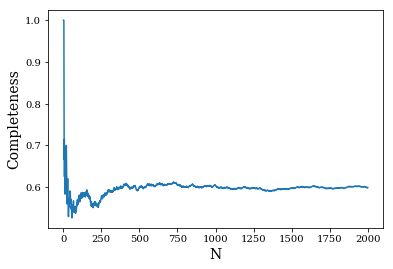

In [7]:
galaxy_number_array = np.asarray(galaxy_number)
galaxy_detection_array = np.asarray(galaxy_detection)
plt.plot(galaxy_number_array,galaxy_detection_array/galaxy_number_array)
plt.xlabel('N',fontsize=14)
plt.ylabel('Completeness',fontsize=14)

In [7]:
#Completeness = galaxy_detection_array[n-1]/galaxy_number_array[n-1]
Completeness = 1198/2000
exptime_for_completeness = survey_area / imager_size * exptime / 60 / 60
exptime_expected = Nnights * hours_night
print('exptime needed for completeness =', exptime_for_completeness, 'hours')
print('exptime_expected =', exptime_expected, 'hours')

exptime needed for completeness = 250.0 hours
exptime_expected = 400 hours


In [8]:
cosmos_size = np.genfromtxt('cosmos_dwarfs_sizes.txt',names=('RA', 'DEC', 'FLUXRADIUS', 'redshift'))
FLUXRADIUS = cosmos_size['FLUXRADIUS']*0.03
redshift_cosmos = cosmos_size['redshift']
cosmos_size_kpc = cosmo.angular_diameter_distance(redshift_cosmos).value*FLUXRADIUS/(60*60*180/np.pi)*1000

Text(0,0.5,'N')

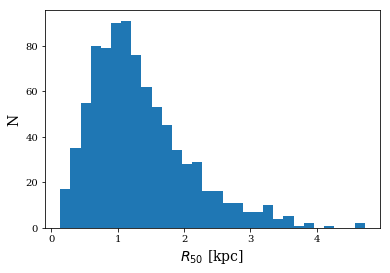

In [9]:
plt.hist(cosmos_size_kpc,bins=30,histtype='stepfilled')
plt.xlabel('$R_{50}$ [kpc]',fontsize=14)
plt.ylabel('N',fontsize=14)

# Optimize the lensing

In [10]:
# Option: use shape noise only (shapenoiseonly=1), or all sources of noise
shapenoiseonly = 0

In [11]:
# Read in the COSMOS GALAXY SMF
SMF_prof=np.genfromtxt('./cosmos2015_dic2017_smf_z01-04_STY0.txt',names=('log_m','log_phi','log_phi_inf','log_phi_sup'))
log_m=SMF_prof['log_m']
log_phi=SMF_prof['log_phi']

In [12]:
# HSC wide
z_source=np.atleast_1d([0.81])   # mean redshift of sources
sigma_gamma=0.28
n_s_arcmin=18.5 #n sources per arcmin^2
survey_area=1000.0 #in deg^-2

z_lens_min=0.02
z_lens_max=0.20
z_lens_mean =0.11 # Got this value from data

# Range of lens M*
Ms_min = 8.0
Ms_max = 9.0

# Corresponding DS file
DS_prof=np.genfromtxt('./dwarf_smooth_model_8_9.txt',names=('rp','DS'))

In [13]:
z_lens=np.atleast_1d([z_lens_mean])

In [14]:
# Get the number density of lenses by integrating the SMF
# and shot noise

SMF = interp1d(log_m, log_phi, kind=3)
x_SMF = np.linspace(0,13,10000)
Phi_interp1d = SMF(x_SMF)
SMF_new = interp1d(x_SMF, pow(10,Phi_interp1d), kind=3)
phiintegral = integrate.quad(lambda x: SMF_new(x), Ms_min, Ms_max)[0]
n_g = phiintegral * Completeness
g_shot_noise=1./n_g

In [15]:
# Set up the R binning in DS
dlogr=np.gradient(np.log10(DS_prof['rp']))[0]
rmin=0.005 #10**(np.log10(DS_prof['rp'][0])-dlogr/2)
rmax=1.9 #10**(np.log10(DS_prof['rp'][-1])+dlogr/2)
nbins=len(DS_prof['rp'])

rp_bins=np.logspace(np.log10(rmin),np.log10(rmax),nbins+1)

In [16]:
#Set up a new set of parameters for power spectra and correlation functions
PS=Power_Spectra()
PS.pk_params['kmax']=520
PS.pk_params['kmin']=1e-2
PS.pk_params['non_linear']=1
rmin=0.005
rmax=1.9

In [17]:
cosmo_params=dict({'h':cosmo.h,'Omb':cosmo.Ob0,'Omd':cosmo.Odm0,'Om':cosmo.Om0,
                'As':2.14e-09,'mnu':cosmo.m_nu[-1].value,'Omk':cosmo.Ok0,'tau':0.06,'ns':0.965,
                  'w':-1,'wa':0})

In [18]:
pk,kh=PS.class_pk(z_lens,cosmo_params=cosmo_params,pk_params=pk_params,return_s8=False)
h=cosmo.h
k=kh*h
pk=pk/h**3
rho=PS.Rho_crit(cosmo=cosmo)*cosmo.Om0

In [19]:
#Setting up the Hankel Transform
#This deals with the interpolation over the Bessel Functions
#This part is slower. But only needs to be run once. 
#If you only need wgg, set j_nu=[0]. For wg+ (or \Delta\Sigma) use j_nu=[2]
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=PS.pk_params['kmax'],j_nu=[2],n_zeros=80000,kmin=PS.pk_params['kmin'],prune_r=0)
%time HT_inv=hankel_transform(rmin=PS.pk_params['kmin'],rmax=PS.pk_params['kmax'],kmax=rmax,j_nu=[2],n_zeros=80000,kmin=rmin,prune_r=50)
#HT=hankel_transform(rmin=1,rmax=rmax,kmax=1,j_nu=[0,2],n_zeros=2800,kmin=1.e-2)#quick test... inaccurate

changed kmax to 1027.1244603681366  to cover rmin
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 81000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 82000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 83000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 84000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 85000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 86000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 87000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 88000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 89000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 90000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 91000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 92000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 93000
j-nu= 2  not enough zeros t

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 105000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 106000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 107000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 108000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 109000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 110000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 111000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 112000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 113000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 114000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 115000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 116000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 117000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to

In [20]:
x=HT_inv.k[2]>DS_prof['rp'].max()
DS2=DS_prof['DS'][-1]*DS_prof['rp'][-1]/HT_inv.k[2][x]
DS2=np.append(DS_prof['DS'],DS2)
rp2=np.append(DS_prof['rp'],HT_inv.k[2][x]) #this doesnot help
#DS2 = savgol_filter(DS2, 5, 3) # window size 51, polynomial order 3

In [21]:
k2,p_gk2=HT_inv.projected_correlation(k_pk=rp2,pk=DS2,j_nu=2)
p_gk2*=(2*np.pi)**2 #factors due to fourier convention
# p_gk2*=(HT.kmax[2]**2/HT.rmax[2]**2) #https://www.gnu.org/software/gsl/doc/html/dht.html
#p_gk2 = savgol_filter(p_gk2, 21, 3) # window size 51, polynomial order 3

In [22]:
# This is just for the clustering term
# In the future could do more sophisticated model for bias of clustering
# by measuring the clustering in the simulation
# Could do a b1 and b2 term
# shouldnt have a large impact on the errors though
b_g=1
p_g=b_g**2*pk[0]
p_gk=b_g*pk[0]*rho

In [23]:
r_th,DS_th2=HT.projected_correlation(k_pk=k2,pk=p_gk2,j_nu=2)
r_th,DS_th=HT.projected_correlation(k_pk=k,pk=p_gk,j_nu=2)

In [24]:
rp,DS_th_b=HT.bin_mat(r=r_th,r_bins=rp_bins,mat=DS_th) #bin the theory predictions
rp,DS_th_b2=HT.bin_mat(r=r_th,r_bins=rp_bins,mat=DS_th2) #bin the theory predictions

In [25]:
# This is the comoving distance between zlens_min and zlens_max
# line of sight window lenght
# redshift bins lens Mpc
L_W=cosmo.angular_diameter_distance(z_lens_max)-cosmo.angular_diameter_distance(z_lens_min)
L_W=L_W.value

area_comoving=survey_area*(np.pi/180)**2*cosmo.angular_diameter_distance(z_lens_mean)**2

In [26]:
#check H0 and comoving physical
sigma_crit=PS.sigma_crit(zl=z_lens,zs=z_source,cosmo=cosmo)
sigma_crit=sigma_crit[0,0].value

In [27]:
d2r=np.pi/180.
n_s=n_s_arcmin*3600/d2r**2
shape_noise=sigma_gamma**2/n_s

In [28]:
l,cl_kappa_kappa=PS.kappa_cl(zs1=z_source,p_zs1=[1],zs2=z_source,p_zs2=[1],zl_max=z_source,n_zl=100,
                             l=np.arange(5.e5),cosmo=cosmo,cl_z_func=PS.pk_l_z)
chi=cosmo.angular_diameter_distance(z_lens)
k_l=(l+0.5)/chi
cl_intp=interp1d(k_l,cl_kappa_kappa,bounds_error=False,fill_value=0)

/Users/yifei/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/yifei/work/dwarf/computesn/power_spectra.py:279: RuntimeWarning: divide by zero encountered in true_divide
  f=(l+0.5)**2/(l*(l+1.)) #correction from Kilbinger+ 2017


In [29]:
l,cl_kappa_kappa=PS.kappa_cl(zs1=z_source,p_zs1=[1],zs2=z_source,p_zs2=[1],zl_max=z_source,n_zl=100,
                             l=np.arange(5.e5),cosmo=cosmo,cl_z_func=PS.pk_l_z)
chi=cosmo.angular_diameter_distance(z_lens)
k_l=(l+0.5)/chi
cl_intp=interp1d(k_l,cl_kappa_kappa,bounds_error=False,fill_value=0)

# approximation of convergence power spectrum p_kappa_kappa
# integration over LOS window function

# cl_z_func=PS.cl_z: Returns cl_\kappa\kappa. Multiply with chi**2 to get in units of projected power spectra (approximate, older version. Not recommended for main results).
# cl_z_func=PS.pk_l_z: Returns P_\kappa\kappa, in units of projected power spectra. Introduced in updated version. Use for main results.

# YIFEI CHECK HERE!!!
# Comment out here to change
if shapenoiseonly == 1:
    p_kappa_kappa=sigma_crit**2*(cl_intp(k)*0+shape_noise)*chi**2 #shape noise only    
else:
#   p_kappa_kappa=sigma_crit**2*(cl_intp(k)+shape_noise)*chi**2  #all noise ... for older approximate version
    p_kappa_kappa=sigma_crit**2*(cl_intp(k)*u.Mpc**2+shape_noise*chi**2)  #all noise .. for updated version (chi**2 is now inside brackets)

/Users/yifei/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/yifei/work/dwarf/computesn/power_spectra.py:279: RuntimeWarning: divide by zero encountered in true_divide
  f=(l+0.5)**2/(l*(l+1.)) #correction from Kilbinger+ 2017


In [30]:
taper_kw=dict({'large_k_lower':500,'large_k_upper':PS.pk_params['kmax'],'low_k_lower':PS.pk_params['kmin'],
               'low_k_upper':PS.pk_params['kmin']*1.2})

In [31]:
# Pgg x Pgammagamma

if shapenoiseonly == 1:
    r,cov_ggkk=HT.projected_covariance(k_pk=k,pk1=p_g*0+g_shot_noise,pk2=p_kappa_kappa,j_nu=2,taper=True,**taper_kw) #shape noise only
else:
    r,cov_ggkk=HT.projected_covariance(k_pk=k,pk1=p_g+g_shot_noise,pk2=p_kappa_kappa,j_nu=2,taper=True,**taper_kw) #all noise


r_re,cov_ggkk_re=HT.bin_cov(r=r,cov=cov_ggkk,r_bins=rp_bins)
corr=HT.corr_matrix(cov=cov_ggkk_re)

/Users/yifei/work/dwarf/computesn/hankel_transform.py:138: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [32]:
#### ***** YIFEI CHECK HERE

r,cov_gkgk=HT.projected_covariance(k_pk=k,pk1=p_gk,pk2=p_gk,j_nu=2,taper=True,**taper_kw)#return_Jrr=True,Jrr=Jrr
#Donot use gkgk when doing noise only
r_re,cov_gkgk_re=HT.bin_cov(r=r,cov=cov_gkgk,r_bins=rp_bins)
corr=HT.corr_matrix(cov=cov_gkgk_re)

/Users/yifei/work/dwarf/computesn/hankel_transform.py:138: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [33]:
# Pgg x Pgammagamma

cov_ggkk_re/=(area_comoving.value*L_W)
cov_gkgk_re/=area_comoving.value

if shapenoiseonly == 1:
    cov_final=cov_ggkk_re #shape noise only    
else:
    cov_final=(cov_ggkk_re+cov_gkgk_re)#/area_comoving.value #all noise

corr=HT.corr_matrix(cov=cov_final)
errors=HT.diagonal_err(cov=cov_final)
errors_ggkk=HT.diagonal_err(cov=cov_ggkk_re)
errors_gkgk=HT.diagonal_err(cov=cov_gkgk_re)

/Users/yifei/work/dwarf/computesn/hankel_transform.py:138: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


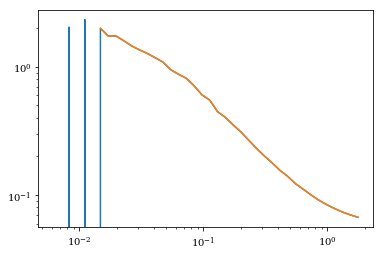

In [43]:
noise_func = interp1d(r_re[2:41], errors_ggkk[2:41], kind=1)
x_noise = np.linspace(r_re[7],r_re[40],100000)
noise_interp1d = noise_func(x_noise)

plt.plot(r_re[1:41],errors_ggkk[1:41])
plt.plot(x_noise,noise_interp1d)
plt.xscale("log")
plt.yscale("log")
plt.xlim()
plt.show()

DS_error = noise_func(DS_prof['rp'][0:41])

In [ ]:
print('r_mpc =', DS_prof['rp'][0:41])
print('DS =', DS_prof['DS'])
print('DS_error =', DS_error)
print('SN =', DS_prof['DS']/DS_error)

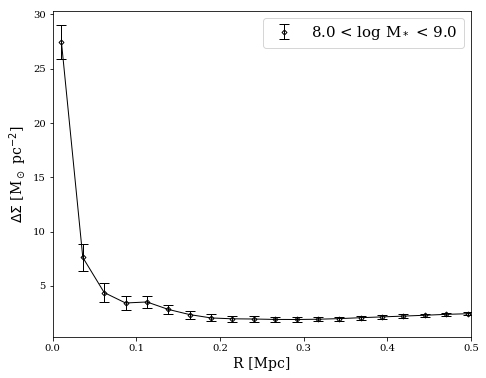

In [67]:
r_mpc = DS_prof['rp'][0:41]
DSigma_origin = DS_prof['DS']
DSigma_origin_err = DS_error

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams["font.family"] = "serif"
plt.figure(figsize=(7.5,6))
plt.plot(r_mpc,DSigma_origin,color='k',linewidth=1)
plt.errorbar(r_mpc,DSigma_origin, yerr=DSigma_origin_err,fmt='D',markersize=3.5,
             capsize=5,ecolor='k',color='k',mfc='none',elinewidth=1,label='8.0 < log M$_*$ < 9.0')
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0,0.5)
plt.xlabel('R [Mpc]',fontsize=14)
plt.ylabel('$\Delta\Sigma$ [M$_\odot$ pc$^{-2}$]',fontsize=14)
plt.legend(fontsize=15)

In [ ]:
# Save the results in a file
# save resultfile here
#result = np.array([DS_prof['rp'][1:40],DS_prof['DS'][1:40],errors_ggkk[1:40]])
#result = np.array([DS_prof['rp'],DS_prof['DS'],DS_error])
#result = result.T
#np.savetxt(resultfile,result,fmt='%.7f',delimiter=' ',newline='\n',header=headernote,footer='')